### Aquiring and importing night-lights data 

Imagery displaying observed light at night over the country of Burundi was downloaded from the NOAA VIIRS website: https://ngdc.noaa.gov/eog/viirs/download_ut_mos.html Burundi is contained within Tile 5, just slightly below the equator. 

We will use satellite day and night time from 2017. Burundi's dry season spans June to late September. Imagery will be collected as close to August 15th, 2017 to minimize noise created from seasonality between the datasets and increase the likelhood the images will be cloud free. 


#### Preprocessing: 

Images downloaded from the above website are free of inherent geographic information. To convert the image from png to tiff while applying the coordinate system, I the following gdal command via the cli: 

```
gdal_translate  -a_srs EPSG:4326  -co compress=LZW SVDNB_npp_d20170815.d.00N060W.png Burundi_20170815.tiff
```

In [16]:
import os
import warnings
from pprint import pprint
import descarteslabs as dl

In [17]:
# *************FIND COUNTRY BOUNDARY ***************
matches = dl.places.find('burundi')
aoi = matches[0]
pprint(aoi)

# This area of interest just gives us some basic properties such as bounding boxes.
# To access a GeoJSON Geometry object of that place, we call the `Places.shape` method, in this case
# accessing a low-resolution version of this particular shape.
shape = dl.places.shape(aoi['slug'], geom='low')

{'bbox': [29.001302, -4.468538, 30.849959, -2.309987],
 'id': 85632285,
 'name': 'Burundi',
 'path': 'continent:africa_country:burundi',
 'placetype': 'country',
 'slug': 'africa_burundi'}


In [35]:
# *************OPEN AN EXISTING IMAGE FROM DISK ***************
from osgeo import gdal
import numpy as np
raster_data_path = "data/black-marble/20170820.tiff"
raster = gdal.Open(raster_data_path, gdal.GA_ReadOnly)

raster_dataset = gdal.Translate("data/black-marble/20170820_clipped.tiff", raster, projWin = [28.9495224, -2.4757, 30.7650, -4.3251151])
#     <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x1a16aa4db0> >


In [36]:
geo_transform = raster_dataset.GetGeoTransform()
#     (416415.0, 30.0, 0.0, 6663145.0, 0.0, -30.0)
proj = raster_dataset.GetProjectionRef()
#     PROJCS["WGS 84 / UTM zone 20S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32720"]]
bands_data = []
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())
#     [array dtype=float32],[...], ...
bands_data = np.dstack(bands_data)


# Validate data
rows, cols, n_bands = bands_data.shape
print (rows, cols, n_bands)

444 436 1


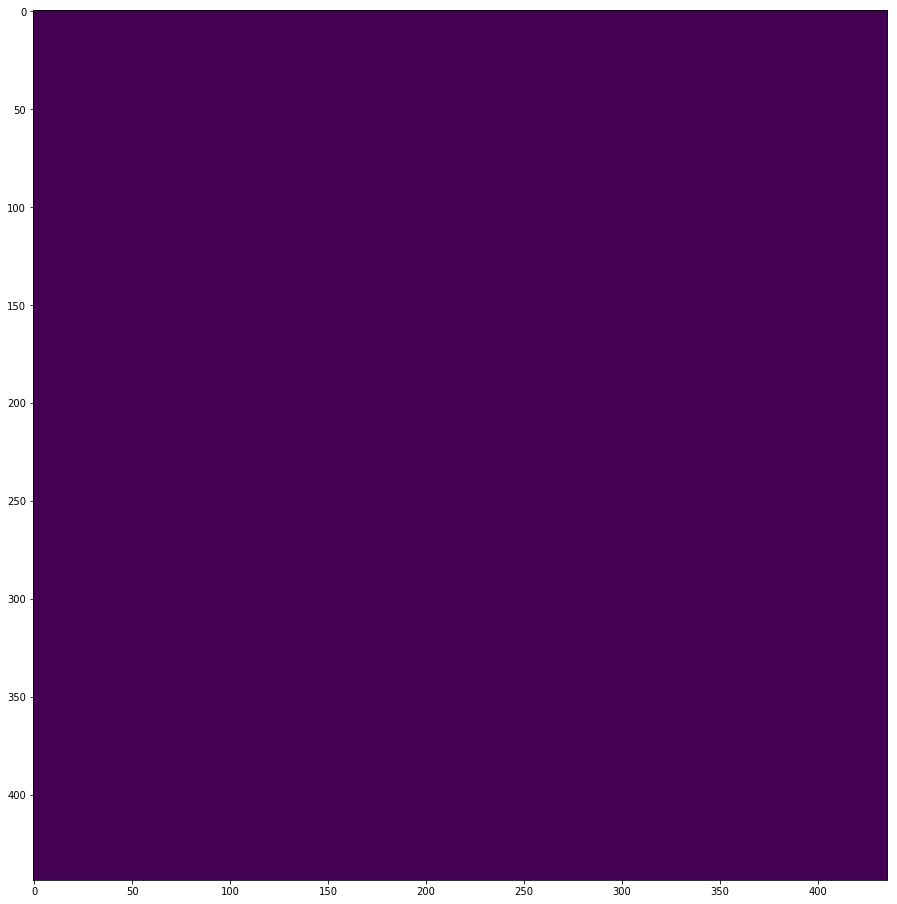

In [37]:
# *************PLOT SINGLE IMAGE ***************

import matplotlib.pyplot as plt
%matplotlib inline


# matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
# https://stackoverflow.com/questions/36431496/typeerror-invalid-dimensions-for-image-data-when-plotting-array-with-imshow
# We need to add an axis for plotting 
plot_data = bands_data.squeeze()

plot_data.shape


plt.figure(figsize=[16,16])
plt.imshow(plot_data)

### Classification

We need a library of functions to rasterize our training and test data for analysis:

In [ ]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

Define training data:

In [ ]:
dl.utilities

Next Steps:

*** 1. Test techniques on Sattelite and NightLight sample data in each of their respective notebooks, starting with the satellite imagery. ***
    
2. Complete the datasets - Identify all day Landsat 8 images over Burundi for the given Black Marble and output image from the year with less than 10% cloud cover.

3. Output the images, and select a subset that covers the country.